## Cell-Aaverage Constant False Alarm Rate for pixel-wise ship detection

CA-CFAR model from the article: [Object Detection with Automotive Radar Sensors using CFAR Algorithms](https://www.jku.at/fileadmin/gruppen/183/Docs/Finished_Theses/Bachelor_Thesis_Katzlberger_final.pdf)

Dataset can be aqcuired [here:](https://gitlab.com/sarmaps/sar-ship-dataset), and the pre-processing description [here:](https://ieeexplore.ieee.org/document/7729017/algorithms?tabFilter=dataset#algorithms)


In [ ]:
import os
from os.path import join
import numpy as np 
import pandas as pd 
from scipy import signal
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline
import time

import sys
sys.path.append('/home/mkhudinyan/GitHub/sar_ship_detect/scripts')
from utils import bbox_draw, data_extractor
from cfar import CA_CFAR, OS_CFAR

In [2]:
PATH = '/home/mkhudinyan/GitHub/sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [3]:
os.listdir(data_path)

['true_negatives.json', 'false_positives.json', 'ship_positives.json']

### Data Pre-processing
###### As we carry a pixel-wise classification, we will pick up only the dataset containing ships `(ship_positives)`.

Dataset presents 1596 ship containing SAR image chips from `Sentinel-1` (Extra Wide Swath) and `RADARSAT-2` sensors. 

In [4]:
#Load the data.
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
print('true_positives: ',ship_positives.shape)
true_negative = pd.read_json(join(data_path, 'true_negatives.json'))

true_positives:  (1, 1596)


In [5]:
# the following information is provided for each of the ship data
ship_positives[0][0].keys()

dict_keys(['id', 'sensor', 'resolution', 'fullname', 'polarisation', 'incidenceangle', 'row', 'column', 'longitude', 'latitude', 'stats', 'R', 'nearest', 'pixelsize', 'patchfu', 'patchgt', 'windowfu', 'windowgt', 'validais', 'ais', 'aux'])

In [5]:
# check the polarisation mode of the dataset
pol = [ship_positives[i][0]['polarisation'] for i in range(ship_positives.size)]
sen = [ship_positives[i][0]['sensor'] for i in range(ship_positives.size)]
pd.Series(Counter(pol)), pd.Series(Counter(sen))


(HH    231
 HV    149
 VV    559
 VH    657
 dtype: int64,
 SEN1    1496
 RSAT     100
 dtype: int64)

In [6]:
# print SAR imahe chip size
np.array(ship_positives[0][0]['patchgt']).shape

(101, 101)

In [6]:
# dsize = (101, 101)

# get true positive data
data = ship_positive_data = data_extractor(ship_positives, 'patchfu') # patchfu-101 |windowfu -21
# get the pixel based classes 
target = ship_positive_target = data_extractor(ship_positives, 'patchgt') # patchgt -101 |windowgt -21

In [8]:
# patchfu
data_extractor(ship_positives, 'windowfu').shape, data_extractor(ship_positives, 'patchfu').shape


((1596, 21, 21), (1596, 101, 101))

<Figure size 432x288 with 0 Axes>

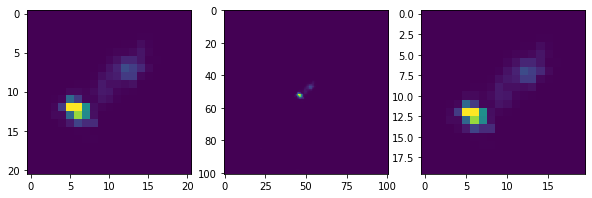

In [9]:
patchfu = data_extractor(ship_positives, 'patchfu')[0]
patchfu_21 = patchfu[patchfu.shape[0]//2 - 10 : patchfu.shape[0]//2 + 10,
                     patchfu.shape[1]//2 - 10 : patchfu.shape[1]//2 + 10 ]
# plt.imshow(data_extractor(ship_positives, 'patchfu')[0])
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(data_extractor(ship_positives, 'windowfu')[0])
axarr[1].imshow(data_extractor(ship_positives, 'patchfu')[0])
axarr[2].imshow(patchfu_21)  

In [15]:
# Resize the images
# dsize = (80, 80)
# ship_positive_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_data])
# target_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST ) for image in ship_positive_target])

In [13]:
# renam the variables for the sake of ease
# data = ship_positive_data
# target = ship_positive_target

In [21]:
print('Data shape:\t', data.shape)
print('Target shape:\t',target.shape)

Data shape:	 (1596, 101, 101)
Target shape:	 (1596, 101, 101)


### Data visualization

Text(0.5, 1.0, 'radar data')

<Figure size 432x288 with 0 Axes>

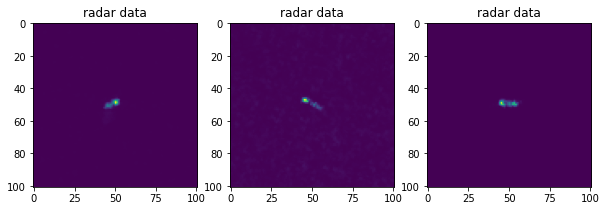

In [10]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(data[1200,:,:])
axarr[0].set_title('radar data')
axarr[1].imshow(data[14,:,:])  
axarr[1].set_title('radar data')
axarr[2].imshow(data[43,:,:])
axarr[2].set_title('radar data')

Text(0.5, 1.0, 'target data')

<Figure size 432x288 with 0 Axes>

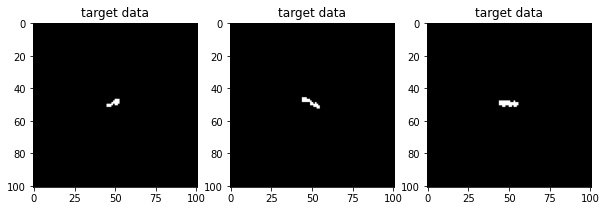

In [11]:
# visualize target samples
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

axarr[0].imshow(target[1200,:,:], cmap="gray") 
axarr[0].set_title('target data')
axarr[1].imshow(target[14,:,:], cmap="gray") 
axarr[1].set_title('target data')
axarr[2].imshow(target[43,:,:], cmap="gray") 
axarr[2].set_title('target data')

### Run CA-CFAR analysis

In [ ]:
# Define parameters for CFAR
kernel_params = [[8, 8, 1, 1], [10, 10, 1, 1], [10, 10, 2, 2], [11, 11, 2, 2]]
P_fa = [8e-4, 10e-4, 12e-4]
labels = ['0-not ship', '1-ship']

# detedt_cfar = np.array([CA_CFAR(image, params, P_fa) for image in data])

In [ ]:
results = {}
for p_fa in P_fa:
    print(f'P_fa: {p_fa}')
    print('#============')

    results[f'P_fa_{p_fa}'] = {}

    for kernel in kernel_params:
        t0 = time.time()

        detedt_cfar = np.array([CA_CFAR(image, kernel, p_fa) for image in data])

        t1 = time.time()
        run_time = round((t1-t0)/60, 2)
        
        results[f'P_fa_{p_fa}'][f'kernel_{kernel}'] = detedt_cfar
        report = classification_report(target.flatten(), detedt_cfar.flatten(), 
                                        target_names=labels, output_dict=False)
    #     results[f'cfar_analysis_report_{i[2]}'] = report
        print(f'Kernel size: {kernel} runtime: {run_time} mins \n', report)
        print('#------------')
    print('#-------------------------------------------------------------------')

P_fa: 0.0008
#============
Kernel size: [8, 8, 1, 1] runtime: 0.23 mins 
               precision    recall  f1-score   support

  0-not ship       1.00      1.00      1.00  16255900
      1-ship       0.26      0.72      0.38     24896

    accuracy                           1.00  16280796
   macro avg       0.63      0.86      0.69  16280796
weighted avg       1.00      1.00      1.00  16280796

#------------
Kernel size: [10, 10, 1, 1] runtime: 0.37 mins 
               precision    recall  f1-score   support

  0-not ship       1.00      1.00      1.00  16255900
      1-ship       0.26      0.82      0.40     24896

    accuracy                           1.00  16280796
   macro avg       0.63      0.91      0.70  16280796
weighted avg       1.00      1.00      1.00  16280796

#------------
Kernel size: [10, 10, 2, 2] runtime: 0.36 mins 
               precision    recall  f1-score   support

  0-not ship       1.00      1.00      1.00  16255900
      1-ship       0.26      0.86    

### Visualize the classification outputs 
Let's plot some images to compare the `actual data vs predicted data`, and `actual labels vs predicted labels`. One should keep in mind that the images undergone to size transformation.

### Draw bound boxes 
The bboxes are created based on binary classification and it will fail if we try to apply on another type of images. Also one should ensure that inputs are 2d_arrays. If we pass also predicted data values of an image, the function returns bbox around the data values while vizualizing also the prediction labels on another image. However, it will still calculate the bbox parameters from label image.

In [ ]:
results['P_fa_0.001'].keys()

dict_keys(['kernel_[10, 10, 1, 1]', 'kernel_[10, 10, 2, 2]', 'kernel_[8, 8, 1, 1]'])

NameError: name 'results' is not defined

<Figure size 432x288 with 0 Axes>

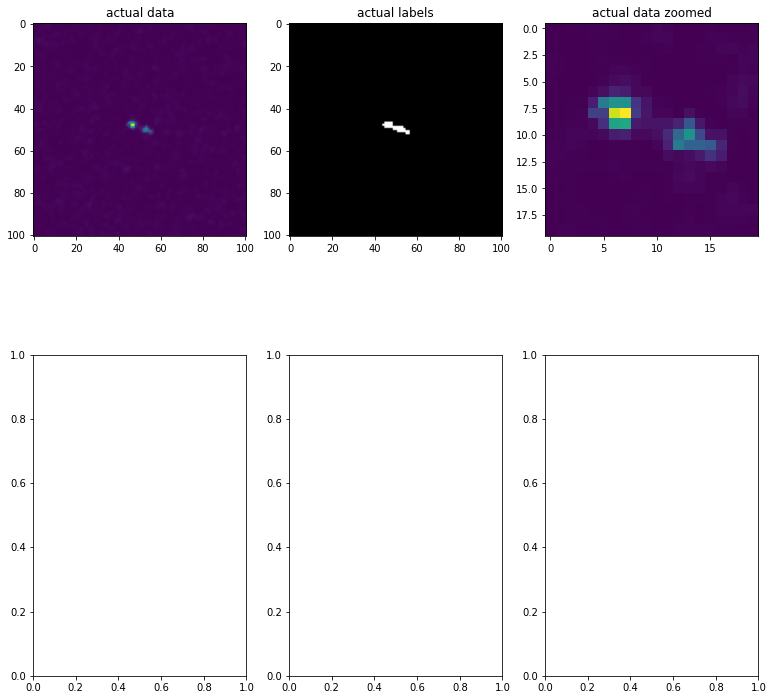

In [10]:
# define functions for vizualization 
def multiple_im_plot(no_image):

    vessel_chip = data[no_image]
    vessel = vessel_chip[vessel_chip.shape[0]//2 - 10 : vessel_chip.shape[0]//2 + 10,
                     vessel_chip.shape[1]//2 - 10 : vessel_chip.shape[1]//2 + 10 ]
    
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(2,3, figsize=(13, 13)) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0,0].imshow(data[no_image])
    axarr[0,0].set_title('actual data')
    axarr[0,1].imshow(target[no_image], cmap="gray")
    axarr[0,1].set_title('actual labels')
    axarr[0,2].imshow(vessel)
    axarr[0,2].set_title('actual data zoomed')


    axarr[1,0].imshow(results['P_fa_0.001']['kernel_[10, 10, 1, 1]'][no_image], cmap="gray")
    axarr[1,0].set_title('predicted labels')
    axarr[1,1].imshow(results['P_fa_0.001']['kernel_[11, 11, 2, 2]'][no_image], cmap="gray") 
    axarr[1,1].set_title('predicted labels')
    axarr[1,2].imshow(results['P_fa_0.001']['kernel_[8, 8, 1, 1]'][no_image], cmap="gray")
    axarr[1,2].set_title('predicted labels')
    
# visualize prediction examples 
multiple_im_plot(15)   

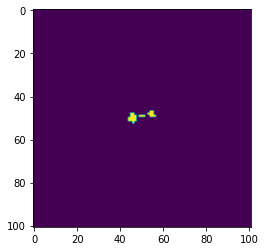

In [13]:
image = data[1]
params = [10, 10, 1, 1]
P_fa = 1e-3
vessel_reg = CA_CFAR(image, params, P_fa)

plt.imshow(vessel_reg)

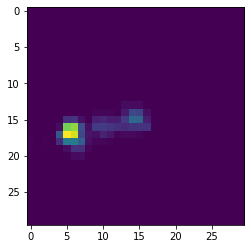

In [14]:
from scipy.ndimage import find_objects, label
labels, _ = label(vessel_reg)
onjects = find_objects(labels)

obj_1 = onjects[0]

center_obj = ((obj_1[0].start + obj_1[0].stop)//2,
              (obj_1[1].start + obj_1[1].stop)//2)

small_chip = image[ center_obj[0] - 15 : center_obj[0] + 15,
                    center_obj[1] - 15 : center_obj[1] + 15]

plt.imshow(small_chip)

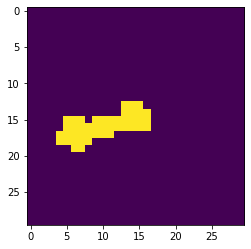

In [15]:
params_vessel = [15, 15, 1, 1]
P_fa_vessel = 1e-1
vessel = CA_CFAR(small_chip, params_vessel, P_fa_vessel)

plt.imshow(vessel)

#### OS_CFAR vessel detector

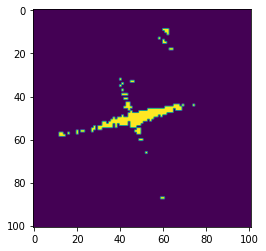

In [21]:
image = data[1]
params = [12, 12, 4, 4]
P_fa = 1e-18
vessel = OS_CFAR(image, params, P_fa, 3)

plt.imshow(vessel)

<a list of 17 BarContainer objects>

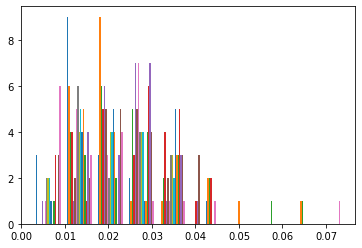

In [27]:
c = image[:mask.shape[0], :mask.shape[1]]

plt.hist(c)[-1]

In [19]:
win_width = params[0]
win_height = params[1]
guard_width = params[2]
guard_height = params[3]

# Create window mask with guard cells
mask = np.ones((2 * win_height + 1, 2 * win_width + 1), dtype=bool)
mask[win_height - guard_height:win_height + 1 + guard_height,
        win_width - guard_width:win_width + 1 + guard_width] = 0

<a list of 21 BarContainer objects>

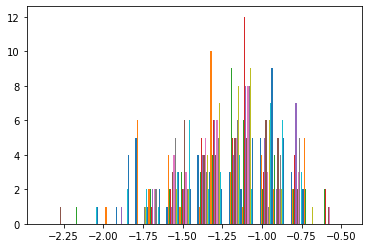

In [41]:
plt.hist(np.log10(c))[2]